In [15]:
n <- 10000 #Tamaño de la población
size_a <- 1000 #Tamaño de la muestra no probabilística

xi <- rnorm(n, mean = 2, sd = 1) # Generamos xi a partir de una distribución normal N(2, 1)
ei <- rnorm(n, mean = 0, sd = sqrt(0.51)) # Generamos ei a partir de una distribución normal N(0, 0.51)
yi <- 3 + 0.7 * (xi - 2) + ei # Calculamos yi usando la ecuación yi = 3 + 0.7(xi - 2) + ei
ui <- rnorm(n, mean = 0, sd = 0.5) # Generamos ui a partir de una distribución normal N(0, 0.5^2)
yi_ast <- 2 + 0.9 * (yi - 3) + ui # Calculamos yi_ast usando la ecuación yi_ast = 2 + 0.9(yi - 3) + ui
datos_simul <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)

#Creamos la muestra probabilística
datos_simul$muestra_A <- 0
indices_seleccionados <- sample(1:n, size = size_a)
datos_simul$muestra_A[indices_seleccionados] <- 1

#Creamos la muestra no probabilística
size_muestra_B <- 5000
grupo_1 <- which(datos_simul$xi <= 2)  # Indices del grupo con xi <= 2
grupo_2 <- which(datos_simul$xi > 2)   # Indices del grupo con xi > 2
n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 del tamaño de la muestra para grupo_1
n_grupo_2 <- size_muestra_B - n_grupo_1     # El resto (2/5) para grupo_2
muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
datos_simul$muestra_B <- 0
datos_simul$muestra_B[muestras_grupo_1] <- 1
datos_simul$muestra_B[muestras_grupo_2] <- 1

,xi,yi,yi_ast,muestra_A,muestra_B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1.8055325,2.844448,2.1293793,0,1
2,2.3943933,2.342176,1.3436692,0,1
3,0.9631785,1.860783,1.9176751,0,1
4,1.6078820,2.642730,0.9132405,0,1
5,3.0243878,3.023734,2.0500059,0,0
6,0.8369444,2.696996,1.3008383,0,0


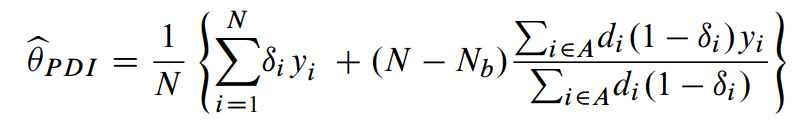

In [25]:
N <- n
Nb <- size_muestra_B

sum_B <- sum(datos_simul$yi[datos_simul$muestra_B == 1])

# Calculamos el estimador de PDI
theta_PDI <- (1 / N) * (
  sum_B +
  (N - Nb) * mean(datos_simul$yi[datos_simul$muestra_A == 1 & datos_simul$muestra_B == 0])
)

# Mostrar el resultado del estimador
theta_PDI


[1] 3.044402

#### Simulación de MonteCarlo del paper (Sin incluir el estimador de calibración)

In [33]:
# ---- Configuración inicial ----
n <- 10000 # Tamaño de la población
size_a <- 1000 # Tamaño de la muestra probabilística
size_muestra_B <- 5000 # Tamaño de la muestra no probabilística

In [34]:
# ---- Función para generar los datos ----
generar_datos <- function(n) {
  xi <- rnorm(n, mean = 2, sd = 1) # Generamos xi a partir de una distribución normal N(2, 1)
  ei <- rnorm(n, mean = 0, sd = sqrt(0.51)) # Generamos ei a partir de una distribución normal N(0, 0.51)
  yi <- 3 + 0.7 * (xi - 2) + ei # Calculamos yi
  ui <- rnorm(n, mean = 0, sd = 0.5) # Generamos ui a partir de una normal N(0, 0.5^2)
  yi_ast <- 2 + 0.9 * (yi - 3) + ui # Calculamos yi_ast (con error de medición)
  datos <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)
  return(datos)
}

# ---- Función para seleccionar muestras A y B ----
seleccionar_muestras <- function(datos, size_a, size_muestra_B) {
  n <- nrow(datos)
  
  # Muestra A (probabilística)
  datos$muestra_A <- 0
  indices_seleccionados <- sample(1:n, size = size_a)
  datos$muestra_A[indices_seleccionados] <- 1
  
  # Muestra B (no probabilística)
  grupo_1 <- which(datos$xi <= 2)  # Indices del grupo con xi <= 2
  grupo_2 <- which(datos$xi > 2)   # Indices del grupo con xi > 2
  n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 para grupo_1
  n_grupo_2 <- size_muestra_B - n_grupo_1     # 2/5 para grupo_2
  muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
  muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
  datos$muestra_B <- 0
  datos$muestra_B[muestras_grupo_1] <- 1
  datos$muestra_B[muestras_grupo_2] <- 1
  
  return(datos)
}

# ---- Función para calcular theta_PDI en cada escenario ----
calcular_theta_pdi <- function(datos, escenario) {
  N <- nrow(datos)
  Nb <- sum(datos$muestra_B == 1)
  
  if (escenario == 1) {
    # Escenario 1: Usando yi (sin error)
    sum_B <- sum(datos$yi[datos$muestra_B == 1])
    theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean(datos$yi[datos$muestra_A == 1 & datos$muestra_B == 0]))
  } else if (escenario == 2) {
    # Escenario 2: Error en la muestra B (yi_ast para muestra B, yi para muestra A)
    sum_B <- sum(datos$yi_ast[datos$muestra_B == 1])
    theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean(datos$yi[datos$muestra_A == 1 & datos$muestra_B == 0]))
  } else if (escenario == 3) {
    # Escenario 3: Error en la muestra A (yi_ast para muestra A, yi para muestra B)
    sum_B <- sum(datos$yi[datos$muestra_B == 1])
    theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean(datos$yi_ast[datos$muestra_A == 1 & datos$muestra_B == 0]))
  }
  
  return(theta_PDI)
}


In [35]:
# ---- Simulación de Monte Carlo ----
simulacion_montecarlo <- function(n_reps, size_a, size_muestra_B) {
  resultados <- data.frame(
    mean_A_esc1 = numeric(n_reps),
    mean_B_esc1 = numeric(n_reps),
    mean_A_esc2 = numeric(n_reps),
    mean_B_esc2 = numeric(n_reps),
    mean_A_esc3 = numeric(n_reps),
    mean_B_esc3 = numeric(n_reps),
    theta_PDI_esc1 = numeric(n_reps),
    theta_PDI_esc2 = numeric(n_reps),
    theta_PDI_esc3 = numeric(n_reps),
    diff_A_esc1 = numeric(n_reps),
    diff_B_esc1 = numeric(n_reps),
    diff_A_esc2 = numeric(n_reps),
    diff_B_esc2 = numeric(n_reps),
    diff_A_esc3 = numeric(n_reps),
    diff_B_esc3 = numeric(n_reps),
    diff_PDI_esc1 = numeric(n_reps),
    diff_PDI_esc2 = numeric(n_reps),
    diff_PDI_esc3 = numeric(n_reps)
  )
  
  for (rep in 1:n_reps) {
    # Generamos los datos y seleccionamos muestras
    datos_simul <- generar_datos(n)
    datos_simul <- seleccionar_muestras(datos_simul, size_a, size_muestra_B)
    
    # Cálculo de las medias en muestra A y B en los tres escenarios
    mean_A_esc1 <- mean(datos_simul$yi[datos_simul$muestra_A == 1])
    mean_B_esc1 <- mean(datos_simul$yi[datos_simul$muestra_B == 1])
    
    mean_A_esc2 <- mean(datos_simul$yi[datos_simul$muestra_A == 1])
    mean_B_esc2 <- mean(datos_simul$yi_ast[datos_simul$muestra_B == 1])
    
    mean_A_esc3 <- mean(datos_simul$yi_ast[datos_simul$muestra_A == 1])
    mean_B_esc3 <- mean(datos_simul$yi[datos_simul$muestra_B == 1])
    
    # Cálculo de theta_PDI en los tres escenarios
    theta_PDI_esc1 <- calcular_theta_pdi(datos_simul, escenario = 1)
    theta_PDI_esc2 <- calcular_theta_pdi(datos_simul, escenario = 2)
    theta_PDI_esc3 <- calcular_theta_pdi(datos_simul, escenario = 3)
    
    # Guardamos los resultados
    resultados$mean_A_esc1[rep] <- mean_A_esc1
    resultados$mean_B_esc1[rep] <- mean_B_esc1
    resultados$mean_A_esc2[rep] <- mean_A_esc2
    resultados$mean_B_esc2[rep] <- mean_B_esc2
    resultados$mean_A_esc3[rep] <- mean_A_esc3
    resultados$mean_B_esc3[rep] <- mean_B_esc3
    resultados$theta_PDI_esc1[rep] <- theta_PDI_esc1
    resultados$theta_PDI_esc2[rep] <- theta_PDI_esc2
    resultados$theta_PDI_esc3[rep] <- theta_PDI_esc3
    
    # Diferencias con respecto a la media verdadera de la población
    media_poblacion <- mean(datos_simul$yi)
    resultados$diff_A_esc1[rep] <- mean_A_esc1 - media_poblacion
    resultados$diff_B_esc1[rep] <- mean_B_esc1 - media_poblacion
    resultados$diff_A_esc2[rep] <- mean_A_esc2 - media_poblacion
    resultados$diff_B_esc2[rep] <- mean_B_esc2 - media_poblacion
    resultados$diff_A_esc3[rep] <- mean_A_esc3 - media_poblacion
    resultados$diff_B_esc3[rep] <- mean_B_esc3 - media_poblacion
    resultados$diff_PDI_esc1[rep] <- theta_PDI_esc1 - media_poblacion
    resultados$diff_PDI_esc2[rep] <- theta_PDI_esc2 - media_poblacion
    resultados$diff_PDI_esc3[rep] <- theta_PDI_esc3 - media_poblacion
  }
  
  return(resultados)
}

# ---- Ejecución de la simulación de Monte Carlo ----
n_reps <- 1000
resultados_simulacion <- simulacion_montecarlo(n_reps, size_a, size_muestra_B)

In [37]:
# ---- Presentación de resultados en tablas ----
library(dplyr)

# Promedios de las diferencias con respecto a la población
promedios <- resultados_simulacion %>%
  summarise(
    Mean_A_Esc1 = mean(diff_A_esc1),
    Mean_B_Esc1 = mean(diff_B_esc1),
    Theta_PDI_Esc1 = mean(diff_PDI_esc1),
    Mean_A_Esc2 = mean(diff_A_esc2),
    Mean_B_Esc2 = mean(diff_B_esc2),
    Theta_PDI_Esc2 = mean(diff_PDI_esc2),
    Mean_A_Esc3 = mean(diff_A_esc3),
    Mean_B_Esc3 = mean(diff_B_esc3),
    Theta_PDI_Esc3 = mean(diff_PDI_esc3)
  )

# Desviación estándar de las diferencias
desviaciones <- resultados_simulacion %>%
  summarise(
    SD_A_Esc1 = sd(diff_A_esc1),
    SD_B_Esc1 = sd(diff_B_esc1),
    SD_Theta_PDI_Esc1 = sd(diff_PDI_esc1),
    SD_A_Esc2 = sd(diff_A_esc2),
    SD_B_Esc2 = sd(diff_B_esc2),
    SD_Theta_PDI_Esc2 = sd(diff_PDI_esc2),
    SD_A_Esc3 = sd(diff_A_esc3),
    SD_B_Esc3 = sd(diff_B_esc3),
    SD_Theta_PDI_Esc3 = sd(diff_PDI_esc3)
  )

# ---- Organización de los resultados en un solo data.frame ----

# Crear un data frame con los resultados
resultados_finales <- data.frame(
  Escenario = rep(c("Esc 1", "Esc 2", "Esc 3"), each = 3),
  Estimador = rep(c("A", "B", "PDI"), 3),
  Sesgo = c(
    promedios$Mean_A_Esc1, promedios$Mean_B_Esc1, promedios$Theta_PDI_Esc1,
    promedios$Mean_A_Esc2, promedios$Mean_B_Esc2, promedios$Theta_PDI_Esc2,
    promedios$Mean_A_Esc3, promedios$Mean_B_Esc3, promedios$Theta_PDI_Esc3
  ),
  Desviacion = c(
    desviaciones$SD_A_Esc1, desviaciones$SD_B_Esc1, desviaciones$SD_Theta_PDI_Esc1,
    desviaciones$SD_A_Esc2, desviaciones$SD_B_Esc2, desviaciones$SD_Theta_PDI_Esc2,
    desviaciones$SD_A_Esc3, desviaciones$SD_B_Esc3, desviaciones$SD_Theta_PDI_Esc3
  )
)

# Mostrar el data.frame final
resultados_finales

Escenario,Estimador,Sesgo,Desviacion
<chr>,<chr>,<dbl>,<dbl>
Esc 1,A,-0.0007039462,0.02935429
Esc 1,B,-0.1117933110,0.01016108
Esc 1,PDI,-0.0003732152,0.02037333
Esc 2,A,-0.0007039462,0.02935429
Esc 2,B,-1.1003559850,0.01164277
Esc 2,PDI,-0.4946545522,0.02058647
Esc 3,A,-1.0006357189,0.03001390
Esc 3,B,-0.1117933110,0.01016108
Esc 3,PDI,-0.5063026142,0.02115910


#### Creando RegDI

In [1]:
# Cargar librerías necesarias
library(survey)

# Parámetros de simulación
n <- 10000        # Tamaño de la población
size_a <- 1000    # Tamaño de la muestra A
size_muestra_B <- 5000  # Tamaño de la muestra B

# Generación de variables
set.seed(123)  # Para reproducibilidad
xi <- rnorm(n, mean = 2, sd = 1)  # Generamos xi ~ N(2,1)
ei <- rnorm(n, mean = 0, sd = sqrt(0.51))  # Generamos ei ~ N(0,0.51)
yi <- 3 + 0.7 * (xi - 2) + ei  # Calculamos yi
ui <- rnorm(n, mean = 0, sd = 0.5)  # Generamos ui ~ N(0,0.5)
yi_ast <- 2 + 0.9 * (yi - 3) + ui  # Calculamos yi_ast
datos_simul <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)

# Crear la muestra A (probabilística)
datos_simul$muestra_A <- 0
indices_seleccionados <- sample(1:n, size = size_a)
datos_simul$muestra_A[indices_seleccionados] <- 1

# Crear la muestra B (no probabilística)
grupo_1 <- which(datos_simul$xi <= 2)  # Grupo 1: xi <= 2
grupo_2 <- which(datos_simul$xi > 2)   # Grupo 2: xi > 2
n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 para grupo 1
n_grupo_2 <- size_muestra_B - n_grupo_1     # 2/5 para grupo 2
muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
datos_simul$muestra_B <- 0
datos_simul$muestra_B[muestras_grupo_1] <- 1
datos_simul$muestra_B[muestras_grupo_2] <- 1

Warning message:
"package 'survey' was built under R version 4.3.3"
Loading required package: grid

Loading required package: Matrix

Loading required package: survival

Warning message:
"package 'survival' was built under R version 4.3.2"

Attaching package: 'survey'


The following object is masked from 'package:graphics':

    dotchart




In [33]:

# Definir N, Nb y Tb
N <- n
Nb <- sum(datos_simul$muestra_B)
Tb <- sum(datos_simul$yi * datos_simul$muestra_B)

# Definir los pesos de muestreo
datos_simul$d_i <- ifelse(datos_simul$muestra_A == 1, N / size_a, 0)  # d_i = 10 para muestra A

# Variables auxiliares para la calibración
datos_simul$uno <- 1  # Representa N
datos_simul$delta_yi <- datos_simul$muestra_B * datos_simul$yi  # delta_i * y_i

# Crear el diseño de encuesta con los pesos correctos
design <- svydesign(ids = ~1, 
                    data = datos_simul[datos_simul$muestra_A == 1, ], 
                    weights = ~d_i)

# Definir los totales poblacionales nombrados
totals <- c(N, Nb, Tb)
names(totals) <- c("uno", "muestra_B", "delta_yi")

# Realizar la calibración
calibrated_design <- calibrate(
  design,
  formula = ~0 + uno + muestra_B + delta_yi,  # Variables auxiliares
  population = totals
)

# Obtener los pesos calibrados
pesos_calibrados <- weights(calibrated_design)

# Calcular el estimador RegDI
T_regDI <- as.numeric(svymean(~yi, calibrated_design)[1])

# Mostrar el resultado
print(paste("Estimador RegDI:", T_regDI))

# Verificar las restricciones de calibración
calibration_constraints <- svyby(~uno + muestra_B + delta_yi, ~1, calibrated_design, svytotal)
print("Restricciones de calibración:")
print(calibration_constraints)
print("Totales poblacionales conocidos:")
print(totals)

[1] "Estimador RegDI: 2.99036187513306"


ERROR: Error in interaction(): No factors specified


### RegDI montecarlo

In [34]:
#---------Función para calcular theta_PDI con variables de estudio flexibles---------
calcular_theta_pdi <- function(datos, var_A, var_B) {
  N <- nrow(datos)
  Nb <- sum(datos$muestra_B == 1)
  
  # Sumatoria para muestra B
  sum_B <- sum(datos[[var_B]][datos$muestra_B == 1], na.rm = TRUE)
  
  # Media para la parte de la población no cubierta por muestra B
  mean_A <- mean(datos[[var_A]][datos$muestra_A == 1 & datos$muestra_B == 0], na.rm = TRUE)
  
  # Calcular theta_PDI
  theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean_A)
  
  return(theta_PDI)
}

#---------Función para calcular el estimador RegDI con variables de estudio flexibles---------
calcular_RegDI <- function(datos, var_A, var_B, N, size_a) {
  # Crear una copia de los datos para evitar modificar el original
  datos_calib <- datos
  
  # Ajustar la variable de interés según las variables proporcionadas
  datos_calib$y_corrected <- datos_calib[[var_A]]
  
  # Definir la variable de corrección para muestra B si var_B es diferente
  if (var_A != var_B) {
    datos_calib$y_corrected[datos_calib$muestra_B == 1] <- datos_calib[[var_B]][datos_calib$muestra_B == 1]
  }
  
  # Definir variables auxiliares para la calibración
  datos_calib$uno <- 1  # Representa N
  datos_calib$delta_i <- datos_calib$muestra_B  # Indicador de pertenencia a muestra B
  datos_calib$delta_yi <- datos_calib$delta_i * datos_calib$y_corrected  # delta_i * y_corrected
  
  # Seleccionar solo las unidades de la muestra A
  muestra_A_data <- datos_calib[datos_calib$muestra_A == 1, ]
  
  # Asignar pesos de muestreo (d_i = N / size_a)
  muestra_A_data$d_i <- N / size_a
  
  # Definir los totales poblacionales conocidos
  Nb <- sum(datos_calib$muestra_B)
  Tb <- sum(datos_calib$delta_yi, na.rm = TRUE)
  
  totals <- c(N, Nb, Tb)
  names(totals) <- c("uno", "muestra_B", "delta_yi")
  
  # Crear el diseño de encuesta con los pesos correctos
  design <- svydesign(
    ids = ~1,
    data = muestra_A_data,
    weights = ~d_i
  )
  
  # Realizar la calibración sin intercepto
  calibrated_design <- calibrate(
    design,
    formula = ~ uno + muestra_B + delta_yi - 1,  # Excluir el intercepto
    population = totals
  )
  
  # Calcular el estimador RegDI como el total ponderado de y_corrected
  T_RegDI <- svymean(~y_corrected, calibrated_design)
  
  return(as.numeric(T_RegDI))
}

#---------Función para generar los datos---------
generar_datos <- function(n) {
  xi <- rnorm(n, mean = 2, sd = 1)                   # Generamos xi ~ N(2,1)
  ei <- rnorm(n, mean = 0, sd = sqrt(0.51))          # Generamos ei ~ N(0,0.51)
  yi <- 3 + 0.7 * (xi - 2) + ei                       # Calculamos yi
  ui <- rnorm(n, mean = 0, sd = 0.5)                 # Generamos ui ~ N(0,0.5^2)
  yi_ast <- 2 + 0.9 * (yi - 3) + ui                   # Calculamos yi_ast (con error de medición)
  datos <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)
  return(datos)
}

#---------Función para seleccionar muestras A y B---------
seleccionar_muestras <- function(datos, size_a, size_muestra_B) {
  n <- nrow(datos)
  
  # Muestra A (probabilística)
  datos$muestra_A <- 0
  indices_seleccionados <- sample(1:n, size = size_a)
  datos$muestra_A[indices_seleccionados] <- 1
  
  # Muestra B (no probabilística)
  grupo_1 <- which(datos$xi <= 2)  # Grupo 1: xi <= 2
  grupo_2 <- which(datos$xi > 2)   # Grupo 2: xi > 2
  n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 para grupo 1
  n_grupo_2 <- size_muestra_B - n_grupo_1     # 2/5 para grupo 2
  muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
  muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
  datos$muestra_B <- 0
  datos$muestra_B[muestras_grupo_1] <- 1
  datos$muestra_B[muestras_grupo_2] <- 1
  
  return(datos)
}

# Definir las variables para cada escenario
# Escenario 1: "yi" para A y B
# Escenario 2: "yi" para A, "yi_ast" para B
# Escenario 3: "yi_ast" para A, "yi" para B

var_A_list <- list("yi", "yi", "yi_ast")
var_B_list <- list("yi", "yi_ast", "yi")


In [35]:
# Función de simulación de Monte Carlo
simulacion_montecarlo <- function(n_reps, size_a, size_muestra_B, var_A_list, var_B_list) {
  # Inicializar el data.frame para almacenar los resultados
  resultados <- data.frame(
    mean_A_esc1 = numeric(n_reps),
    mean_B_esc1 = numeric(n_reps),
    mean_A_esc2 = numeric(n_reps),
    mean_B_esc2 = numeric(n_reps),
    mean_A_esc3 = numeric(n_reps),
    mean_B_esc3 = numeric(n_reps),
    theta_PDI_esc1 = numeric(n_reps),
    theta_PDI_esc2 = numeric(n_reps),
    theta_PDI_esc3 = numeric(n_reps),
    theta_RegDI_esc1 = numeric(n_reps),
    theta_RegDI_esc2 = numeric(n_reps),
    theta_RegDI_esc3 = numeric(n_reps),
    diff_A_esc1 = numeric(n_reps),
    diff_B_esc1 = numeric(n_reps),
    diff_A_esc2 = numeric(n_reps),
    diff_B_esc2 = numeric(n_reps),
    diff_A_esc3 = numeric(n_reps),
    diff_B_esc3 = numeric(n_reps),
    diff_PDI_esc1 = numeric(n_reps),
    diff_PDI_esc2 = numeric(n_reps),
    diff_PDI_esc3 = numeric(n_reps),
    diff_RegDI_esc1 = numeric(n_reps),
    diff_RegDI_esc2 = numeric(n_reps),
    diff_RegDI_esc3 = numeric(n_reps)
  )
  
  # Bucle de simulación
  for (rep in 1:n_reps) {
    # Generar los datos y seleccionar muestras
    datos_simul <- generar_datos(n)
    datos_simul <- seleccionar_muestras(datos_simul, size_a, size_muestra_B)
    
    # Escenario 1
    esc <- 1
    var_A <- var_A_list[[esc]]
    var_B <- var_B_list[[esc]]
    mean_A_esc1 <- mean(datos_simul[[var_A]][datos_simul$muestra_A == 1], na.rm = TRUE)
    mean_B_esc1 <- mean(datos_simul[[var_B]][datos_simul$muestra_B == 1], na.rm = TRUE)
    theta_PDI_esc1 <- calcular_theta_pdi(datos_simul, var_A = var_A, var_B = var_B)
    theta_RegDI_esc1 <- calcular_RegDI(datos_simul, var_A = var_A, var_B = var_B, N = n, size_a = size_a)
    
    # Escenario 2
    esc <- 2
    var_A <- var_A_list[[esc]]
    var_B <- var_B_list[[esc]]
    mean_A_esc2 <- mean(datos_simul[[var_A]][datos_simul$muestra_A == 1], na.rm = TRUE)
    mean_B_esc2 <- mean(datos_simul[[var_B]][datos_simul$muestra_B == 1], na.rm = TRUE)
    theta_PDI_esc2 <- calcular_theta_pdi(datos_simul, var_A = var_A, var_B = var_B)
    theta_RegDI_esc2 <- calcular_RegDI(datos_simul, var_A = var_A, var_B = var_B, N = n, size_a = size_a)
    
    # Escenario 3
    esc <- 3
    var_A <- var_A_list[[esc]]
    var_B <- var_B_list[[esc]]
    mean_A_esc3 <- mean(datos_simul[[var_A]][datos_simul$muestra_A == 1], na.rm = TRUE)
    mean_B_esc3 <- mean(datos_simul[[var_B]][datos_simul$muestra_B == 1], na.rm = TRUE)
    theta_PDI_esc3 <- calcular_theta_pdi(datos_simul, var_A = var_A, var_B = var_B)
    theta_RegDI_esc3 <- calcular_RegDI(datos_simul, var_A = var_A, var_B = var_B, N = n, size_a = size_a)
    
    # Cálculo de la media verdadera de la población
    media_poblacion <- mean(datos_simul$yi, na.rm = TRUE)
    
    # Guardar los resultados
    resultados$mean_A_esc1[rep] <- mean_A_esc1
    resultados$mean_B_esc1[rep] <- mean_B_esc1
    resultados$mean_A_esc2[rep] <- mean_A_esc2
    resultados$mean_B_esc2[rep] <- mean_B_esc2
    resultados$mean_A_esc3[rep] <- mean_A_esc3
    resultados$mean_B_esc3[rep] <- mean_B_esc3
    resultados$theta_PDI_esc1[rep] <- theta_PDI_esc1
    resultados$theta_PDI_esc2[rep] <- theta_PDI_esc2
    resultados$theta_PDI_esc3[rep] <- theta_PDI_esc3
    resultados$theta_RegDI_esc1[rep] <- theta_RegDI_esc1
    resultados$theta_RegDI_esc2[rep] <- theta_RegDI_esc2
    resultados$theta_RegDI_esc3[rep] <- theta_RegDI_esc3
    
    # Diferencias con respecto a la media verdadera de la población
    resultados$diff_A_esc1[rep] <- mean_A_esc1 - media_poblacion
    resultados$diff_B_esc1[rep] <- mean_B_esc1 - media_poblacion
    resultados$diff_A_esc2[rep] <- mean_A_esc2 - media_poblacion
    resultados$diff_B_esc2[rep] <- mean_B_esc2 - media_poblacion
    resultados$diff_A_esc3[rep] <- mean_A_esc3 - media_poblacion
    resultados$diff_B_esc3[rep] <- mean_B_esc3 - media_poblacion
    resultados$diff_PDI_esc1[rep] <- theta_PDI_esc1 - media_poblacion
    resultados$diff_PDI_esc2[rep] <- theta_PDI_esc2 - media_poblacion
    resultados$diff_PDI_esc3[rep] <- theta_PDI_esc3 - media_poblacion
    resultados$diff_RegDI_esc1[rep] <- theta_RegDI_esc1 - media_poblacion
    resultados$diff_RegDI_esc2[rep] <- theta_RegDI_esc2 - media_poblacion
    resultados$diff_RegDI_esc3[rep] <- theta_RegDI_esc3 - media_poblacion
  }
  
  return(resultados)
}


In [36]:
# Definir las variables para cada escenario
var_A_list <- list("yi", "yi", "yi_ast")
var_B_list <- list("yi", "yi_ast", "yi")

# Definir parámetros de simulación
n_reps <- 1000

# Ejecutar la simulación
resultados_simulacion <- simulacion_montecarlo(
  n_reps = n_reps,
  size_a = size_a,
  size_muestra_B = size_muestra_B,
  var_A_list = var_A_list,
  var_B_list = var_B_list
)


In [37]:
# Cargar librería necesaria
library(dplyr)

# Promedios de las diferencias con respecto a la población
promedios <- resultados_simulacion %>%
  summarise(
    Mean_A_Esc1 = mean(diff_A_esc1),
    Mean_B_Esc1 = mean(diff_B_esc1),
    Theta_PDI_Esc1 = mean(diff_PDI_esc1),
    Theta_RegDI_Esc1 = mean(diff_RegDI_esc1),
    
    Mean_A_Esc2 = mean(diff_A_esc2),
    Mean_B_Esc2 = mean(diff_B_esc2),
    Theta_PDI_Esc2 = mean(diff_PDI_esc2),
    Theta_RegDI_Esc2 = mean(diff_RegDI_esc2),
    
    Mean_A_Esc3 = mean(diff_A_esc3),
    Mean_B_Esc3 = mean(diff_B_esc3),
    Theta_PDI_Esc3 = mean(diff_PDI_esc3),
    Theta_RegDI_Esc3 = mean(diff_RegDI_esc3)
  )

# Desviación estándar de las diferencias
desviaciones <- resultados_simulacion %>%
  summarise(
    SD_A_Esc1 = sd(diff_A_esc1),
    SD_B_Esc1 = sd(diff_B_esc1),
    SD_Theta_PDI_Esc1 = sd(diff_PDI_esc1),
    SD_Theta_RegDI_Esc1 = sd(diff_RegDI_esc1),
    
    SD_A_Esc2 = sd(diff_A_esc2),
    SD_B_Esc2 = sd(diff_B_esc2),
    SD_Theta_PDI_Esc2 = sd(diff_PDI_esc2),
    SD_Theta_RegDI_Esc2 = sd(diff_RegDI_esc2),
    
    SD_A_Esc3 = sd(diff_A_esc3),
    SD_B_Esc3 = sd(diff_B_esc3),
    SD_Theta_PDI_Esc3 = sd(diff_PDI_esc3),
    SD_Theta_RegDI_Esc3 = sd(diff_RegDI_esc3)
  )

# Organización de los resultados en un solo data.frame

# Crear un data frame con los resultados
resultados_finales <- data.frame(
  Escenario = rep(c("Esc 1", "Esc 2", "Esc 3"), each = 4),
  Estimador = rep(c("A", "B", "PDI", "RegDI"), 3),
  Sesgo = c(
    promedios$Mean_A_Esc1, promedios$Mean_B_Esc1, promedios$Theta_PDI_Esc1, promedios$Theta_RegDI_Esc1,
    promedios$Mean_A_Esc2, promedios$Mean_B_Esc2, promedios$Theta_PDI_Esc2, promedios$Theta_RegDI_Esc2,
    promedios$Mean_A_Esc3, promedios$Mean_B_Esc3, promedios$Theta_PDI_Esc3, promedios$Theta_RegDI_Esc3
  ),
  Desviacion = c(
    desviaciones$SD_A_Esc1, desviaciones$SD_B_Esc1, desviaciones$SD_Theta_PDI_Esc1, desviaciones$SD_Theta_RegDI_Esc1,
    desviaciones$SD_A_Esc2, desviaciones$SD_B_Esc2, desviaciones$SD_Theta_PDI_Esc2, desviaciones$SD_Theta_RegDI_Esc2,
    desviaciones$SD_A_Esc3, desviaciones$SD_B_Esc3, desviaciones$SD_Theta_PDI_Esc3, desviaciones$SD_Theta_RegDI_Esc3
  )
)

# Mostrar el data.frame final
print(resultados_finales)



Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




   Escenario Estimador         Sesgo Desviacion
1      Esc 1         A  0.0009130499 0.03094811
2      Esc 1         B -0.1118074629 0.01029603
3      Esc 1       PDI  0.0003650309 0.02189490
4      Esc 1     RegDI  0.0003650309 0.02189490
5      Esc 2         A  0.0009130499 0.03094811
6      Esc 2         B -1.1006666120 0.01193551
7      Esc 2       PDI -0.4940645437 0.02204605
8      Esc 2     RegDI -0.4940645437 0.02204605
9      Esc 3         A -0.9986555386 0.03202407
10     Esc 3         B -0.1118074629 0.01029603
11     Esc 3       PDI -0.5047701605 0.02275184
12     Esc 3     RegDI -0.5047701605 0.02275184


In [41]:
# Ejemplo de verificación en una repetición específica
rep_especifica <- 1
datos_simul <- generar_datos(n)
datos_simul <- seleccionar_muestras(datos_simul, size_a, size_muestra_B)

# Definir las variables para cada escenario
var_A_list <- list("yi", "yi", "yi_ast")
var_B_list <- list("yi", "yi_ast", "yi")

# Escenario 1
theta_RegDI_esc1 <- calcular_RegDI(datos_simul, var_A = var_A_list[[1]], var_B = var_B_list[[1]], N = n, size_a = size_a)

# Crear una copia de los datos para la calibración
datos_calib_espec <- datos_simul
datos_calib_espec$y_corrected <- datos_calib_espec[[var_A_list[[1]]]]

# Definir variables auxiliares para la calibración
datos_calib_espec$uno <- 1
datos_calib_espec$delta_i <- datos_calib_espec$muestra_B
datos_calib_espec$delta_yi <- datos_calib_espec$delta_i * datos_calib_espec$y_corrected

# Seleccionar solo las unidades de la muestra A
muestra_A_data_espec <- datos_calib_espec[datos_calib_espec$muestra_A == 1, ]

# Asignar pesos de muestreo
muestra_A_data_espec$d_i <- n / size_a

# Definir los totales poblacionales conocidos
Nb_espec <- sum(datos_calib_espec$muestra_B)
Tb_espec <- sum(datos_calib_espec$delta_yi, na.rm = TRUE)
totals_espec <- c(n, Nb_espec, Tb_espec)
names(totals_espec) <- c("uno", "muestra_B", "delta_yi")

# Crear el diseño de encuesta
design_espec <- svydesign(
  ids = ~1,
  data = muestra_A_data_espec,
  weights = ~d_i
)

# Realizar la calibración sin intercepto
calibrated_design_espec <- calibrate(
  design_espec,
  formula = ~ uno + muestra_B + delta_yi - 1,
  population = totals_espec
)

# Verificar las restricciones de calibración utilizando svytotal
calibration_constraints <- svytotal(~uno + muestra_B + delta_yi, calibrated_design_espec)
print("Restricciones de calibración (Total Ponderado):")
print(calibration_constraints)
print("Totales poblacionales conocidos:")
print(totals_espec)


[1] "Restricciones de calibración (Total Ponderado):"
          total SE
uno       10000  0
muestra_B  5000  0
delta_yi  14397  0
[1] "Totales poblacionales conocidos:"
      uno muestra_B  delta_yi 
 10000.00   5000.00  14396.92 


### RegDI Modificado, una sola interación

#### Definición de la función RegDI

In [12]:
# Cargar librerías necesarias
library(survey)

# Función corregida RegDI con correcciones adecuadas
RegDI <- function(data, y_A_col, y_B_col, 
                 size_a, size_muestra_B, N = NULL, apply_correction = 0) {
  
  # Determinar N si no se proporciona
  if (is.null(N)) {
    N <- nrow(data)
  }
  
  # Verificar que las columnas especificadas existan en el data frame
  if (!all(c(y_A_col, y_B_col) %in% names(data))) {
    stop("Las columnas especificadas no se encuentran en el data frame.")
  }
  
  # Inicializar columnas de muestra si no existen
  if (!"muestra_A" %in% names(data)) {
    data$muestra_A <- 0
  }
  if (!"muestra_B" %in% names(data)) {
    data$muestra_B <- 0
  }
  
  # Definir los pesos de muestreo iniciales
  data$d_i <- ifelse(data$muestra_A == 1, N / size_a, 0)
  
  # Calcular los totales poblacionales necesarios
  Nb <- sum(data$muestra_B)
  
  # Crear variables auxiliares
  data$uno <- 1
  data$delta_i <- data$muestra_B  # Usar 'delta_i' consistentemente
  data$delta_yi <- data$muestra_B * data[[y_B_col]]
  
  # Crear el diseño de encuesta con los pesos iniciales
  design <- svydesign(ids = ~1, 
                      data = data[data$muestra_A == 1, ], 
                      weights = ~d_i)
  
  # Definir los totales poblacionales
  Tb <- sum(data$delta_yi, na.rm = TRUE)
  totals <- c(N, Nb, Tb)
  names(totals) <- c("uno", "delta_i", "delta_yi")
  
  # Realizar la calibración sin intercepto
  calibrated_design <- calibrate(
    design,
    formula = ~0 + uno + delta_i + delta_yi,  # Sin intercepto
    population = totals
  )
  
  if (apply_correction == 1) {
    # Escenario 2: Errores en la muestra B
    # No se requiere corrección adicional, solo calibración
    # Calcular el estimador RegDI usando y_A_col
    T_RegDI <- as.numeric(svymean(as.formula(paste("~", y_A_col)), 
                                  calibrated_design)[1])
    V_RegDI <- as.numeric(svyvar(as.formula(paste("~", y_A_col)), 
                                 calibrated_design)[1])
    
  } else if (apply_correction == 2) {
    # Escenario 3: Errores en la muestra A
    # Necesitamos corregir y_A_col basado en y_B_col (suponiendo que y_B_col es sin errores)
    
    # Identificar unidades de validación: en muestra A y B
    validation_indices <- which(data$muestra_A == 1 & data$muestra_B == 1)
    
    if (length(validation_indices) < 2) {
      stop("No hay suficientes datos de validación en la muestra A para ajustar el modelo de error de medición.")
    }
    
    # Ajustar el modelo de errores de medición usando datos de validación
    fit <- lm(as.formula(paste(y_A_col, "~", y_B_col)), 
              data = data[validation_indices, ])
    
    beta_0 <- coef(fit)[1]
    beta_1 <- coef(fit)[2]
    
    # Corregir y_A_col para estimar y_i en la muestra A
    data$y_corrected <- data[[y_B_col]]  # Inicialmente igual a y_B_col
    data$y_corrected[data$muestra_A == 1] <- (data[[y_A_col]][data$muestra_A == 1] - beta_0) / beta_1
    
    # Actualizar delta_yi_corrected con y_corrected
    data$delta_yi_corrected <- data$muestra_B * data$y_corrected
    
    # Crear el diseño de encuesta corregido
    design_corrected <- svydesign(
      ids = ~1,
      data = data[data$muestra_A == 1, ],
      weights = ~d_i
    )
    
    # Definir los totales poblacionales con la corrección
    Tb_corrected <- sum(data$delta_yi_corrected, na.rm = TRUE)
    totals_corrected <- c(N, Nb, Tb_corrected)
    names(totals_corrected) <- c("uno", "delta_i", "delta_yi")
    
    # Realizar la calibración con los valores corregidos
    calibrated_design_corrected <- calibrate(
      design_corrected,
      formula = ~0 + uno + delta_i + delta_yi,  # Sin intercepto
      population = totals_corrected
    )
    
    # Calcular el estimador RegDI con corrección
    T_RegDI <- as.numeric(svymean(~y_corrected, 
                                  calibrated_design_corrected)[1])
    V_RegDI <- as.numeric(svyvar(~y_corrected, 
                                 calibrated_design_corrected)[1])
    
  } else {
    # Escenario 1: Sin corrección
    # Calcular el estimador RegDI usando y_A_col
    T_RegDI <- as.numeric(svymean(as.formula(paste("~", y_A_col)), 
                                  calibrated_design)[1])
    V_RegDI <- as.numeric(svyvar(as.formula(paste("~", y_A_col)), 
                                 calibrated_design)[1])
  }
  
  # Retornar el estimador y su varianza
  return(list(T_RegDI = T_RegDI, V_RegDI = V_RegDI))
}


#### Simulación de una sola vez

In [13]:
# Cargar librerías necesarias
library(survey)

# Parámetros de simulación
n <- 10000        # Tamaño de la población
size_a <- 1000    # Tamaño de la muestra A
size_muestra_B <- 5000  # Tamaño de la muestra B

# Generación de variables
set.seed(123)  # Para reproducibilidad
xi <- rnorm(n, mean = 2, sd = 1)  # Generamos xi ~ N(2,1)
ei <- rnorm(n, mean = 0, sd = sqrt(0.51))  # Generamos ei ~ N(0,0.51)
yi <- 3 + 0.7 * (xi - 2) + ei  # Calculamos yi
ui <- rnorm(n, mean = 0, sd = 0.5)  # Generamos ui ~ N(0,0.5)
yi_ast <- 2 + 0.9 * (yi - 3) + ui  # Calculamos yi_ast
datos_simul <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)

# Crear la muestra A (probabilística)
datos_simul$muestra_A <- 0
indices_seleccionados <- sample(1:n, size = size_a)
datos_simul$muestra_A[indices_seleccionados] <- 1

# Crear la muestra B (no probabilística)
grupo_1 <- which(datos_simul$xi <= 2)  # Grupo 1: xi <= 2
grupo_2 <- which(datos_simul$xi > 2)   # Grupo 2: xi > 2
n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 para grupo 1
n_grupo_2 <- size_muestra_B - n_grupo_1     # 2/5 para grupo 2

# Asegurar que hay suficientes unidades en cada grupo
if(length(grupo_1) < n_grupo_1 | length(grupo_2) < n_grupo_2){
  stop("No hay suficientes unidades en alguno de los grupos para seleccionar la muestra B.")
}

muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
datos_simul$muestra_B <- 0
datos_simul$muestra_B[muestras_grupo_1] <- 1
datos_simul$muestra_B[muestras_grupo_2] <- 1


#### Simulaciones por escenario

In [11]:
# Escenario 1: Sin errores de medición
RegDI_esc1 <- RegDI(
  data = datos_simul, 
  y_A_col = "yi", 
  y_B_col = "yi", 
  size_a = size_a, 
  size_muestra_B = size_muestra_B, 
  N = n,
  apply_correction = 0
)

# Escenario 2: Errores en la muestra B
RegDI_esc2 <- RegDI(
  data = datos_simul, 
  y_A_col = "yi", 
  y_B_col = "yi_ast", 
  size_a = size_a, 
  size_muestra_B = size_muestra_B, 
  N = n,
  apply_correction = 1
)
# 
# Escenario 3: Errores en la muestra A
RegDI_esc3 <- RegDI(
  data = datos_simul, 
  # y_A_col = "yi_ast", 
  y_B_col = "yi", 
  size_a = size_a, 
  size_muestra_B = size_muestra_B, 
  N = n,
  apply_correction = 2
)

# Función para calcular theta_PDI
calcular_theta_pdi <- function(datos, var_A, var_B) {
  N <- nrow(datos)
  Nb <- sum(datos$muestra_B == 1)
  
  # Sumatoria para muestra B
  sum_B <- sum(datos[[var_B]][datos$muestra_B == 1], na.rm = TRUE)
  
  # Media para la parte de la población no cubierta por muestra B
  mean_A <- mean(datos[[var_A]][datos$muestra_A == 1 & datos$muestra_B == 0], na.rm = TRUE)
  
  # Calcular theta_PDI
  theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean_A)
  
  return(theta_PDI)
}

# Calcular theta_PDI para cada escenario
theta_PDI_esc1 <- calcular_theta_pdi(datos_simul, var_A = "yi", var_B = "yi")
theta_PDI_esc2 <- calcular_theta_pdi(datos_simul, var_A = "yi", var_B = "yi_ast")
theta_PDI_esc3 <- calcular_theta_pdi(datos_simul, var_A = "yi_ast", var_B = "yi")



#### Montecarlo completo?

In [17]:
# ---- Cargar librerías necesarias ----
library(survey)
library(dplyr)

# ---- Definir la función RegDI ----
RegDI <- function(data, y_A_col, y_B_col, 
                 size_a, size_muestra_B, N = NULL, apply_correction = 0) {
  
  # Determinar N si no se proporciona
  if (is.null(N)) {
    N <- nrow(data)
  }
  
  # Verificar que las columnas especificadas existan en el data frame
  if (!all(c(y_A_col, y_B_col) %in% names(data))) {
    stop("Las columnas especificadas no se encuentran en el data frame.")
  }
  
  # Inicializar columnas de muestra si no existen
  if (!"muestra_A" %in% names(data)) {
    data$muestra_A <- 0
  }
  if (!"muestra_B" %in% names(data)) {
    data$muestra_B <- 0
  }
  
  # Definir los pesos de muestreo iniciales
  data$d_i <- ifelse(data$muestra_A == 1, N / size_a, 0)
  
  # Calcular los totales poblacionales necesarios
  Nb <- sum(data$muestra_B)
  
  # Crear variables auxiliares
  data$uno <- 1
  data$delta_i <- data$muestra_B  # Usar 'delta_i' consistentemente
  data$delta_yi <- data$muestra_B * data[[y_B_col]]
  
  # Crear el diseño de encuesta con los pesos iniciales
  design <- svydesign(ids = ~1, 
                      data = data[data$muestra_A == 1, ], 
                      weights = ~d_i)
  
  # Definir los totales poblacionales
  Tb <- sum(data$delta_yi, na.rm = TRUE)
  totals <- c(N, Nb, Tb)
  names(totals) <- c("uno", "delta_i", "delta_yi")
  
  # Realizar la calibración sin intercepto
  calibrated_design <- calibrate(
    design,
    formula = ~0 + uno + delta_i + delta_yi,  # Sin intercepto
    population = totals
  )
  
  if (apply_correction == 1) {
    # Escenario 2: Errores en la muestra B
    # No se requiere corrección adicional, solo calibración
    # Calcular el estimador RegDI usando y_A_col
    T_RegDI <- as.numeric(svymean(as.formula(paste("~", y_A_col)), 
                                  calibrated_design)[1])
    V_RegDI <- as.numeric(svyvar(as.formula(paste("~", y_A_col)), 
                                 calibrated_design)[1])
    
  } else if (apply_correction == 2) {
    # Escenario 3: Errores en la muestra A
    # Necesitamos corregir y_A_col basado en y_B_col (suponiendo que y_B_col es sin errores)
    
    # Identificar unidades de validación: en muestra A y B
    validation_indices <- which(data$muestra_A == 1 & data$muestra_B == 1)
    
    if (length(validation_indices) < 2) {
      stop("No hay suficientes datos de validación en la muestra A para ajustar el modelo de error de medición.")
    }
    
    # Ajustar el modelo de errores de medición usando datos de validación
    fit <- lm(as.formula(paste(y_A_col, "~", y_B_col)), 
              data = data[validation_indices, ])
    
    beta_0 <- coef(fit)[1]
    beta_1 <- coef(fit)[2]
    
    # Corregir y_A_col para estimar y_i en la muestra A
    data$y_corrected <- data[[y_B_col]]  # Inicialmente igual a y_B_col
    data$y_corrected[data$muestra_A == 1] <- (data[[y_A_col]][data$muestra_A == 1] - beta_0) / beta_1
    
    # Actualizar delta_yi_corrected con y_corrected
    data$delta_yi_corrected <- data$muestra_B * data$y_corrected
    
    # Crear el diseño de encuesta corregido
    design_corrected <- svydesign(
      ids = ~1,
      data = data[data$muestra_A == 1, ],
      weights = ~d_i
    )
    
    # Definir los totales poblacionales con la corrección
    Tb_corrected <- sum(data$delta_yi_corrected, na.rm = TRUE)
    totals_corrected <- c(N, Nb, Tb_corrected)
    names(totals_corrected) <- c("uno", "delta_i", "delta_yi")
    
    # Realizar la calibración con los valores corregidos
    calibrated_design_corrected <- calibrate(
      design_corrected,
      formula = ~0 + uno + delta_i + delta_yi,  # Sin intercepto
      population = totals_corrected
    )
    
    # Calcular el estimador RegDI con corrección
    T_RegDI <- as.numeric(svymean(~y_corrected, 
                                  calibrated_design_corrected)[1])
    V_RegDI <- as.numeric(svyvar(~y_corrected, 
                                 calibrated_design_corrected)[1])
    
  } else {
    # Escenario 1: Sin corrección
    # Calcular el estimador RegDI usando y_A_col
    T_RegDI <- as.numeric(svymean(as.formula(paste("~", y_A_col)), 
                                  calibrated_design)[1])
    V_RegDI <- as.numeric(svyvar(as.formula(paste("~", y_A_col)), 
                                 calibrated_design)[1])
  }
  
  # Retornar el estimador y su varianza
  return(list(T_RegDI = T_RegDI, V_RegDI = V_RegDI))
}

# ---- Definir la función para calcular theta_PDI ----
calcular_theta_pdi <- function(datos, var_A, var_B) {
  N <- nrow(datos)
  Nb <- sum(datos$muestra_B == 1)
  
  # Sumatoria para muestra B
  sum_B <- sum(datos[[var_B]][datos$muestra_B == 1], na.rm = TRUE)
  
  # Media para la parte de la población no cubierta por muestra B
  mean_A <- mean(datos[[var_A]][datos$muestra_A == 1 & datos$muestra_B == 0], na.rm = TRUE)
  
  # Calcular theta_PDI
  theta_PDI <- (1 / N) * (sum_B + (N - Nb) * mean_A)
  
  return(theta_PDI)
}

# ---- Función para generar los datos ----
generar_datos <- function(n) {
  xi <- rnorm(n, mean = 2, sd = 1) # Generamos xi a partir de una distribución normal N(2, 1)
  ei <- rnorm(n, mean = 0, sd = sqrt(0.51)) # Generamos ei a partir de una distribución normal N(0, 0.51)
  yi <- 3 + 0.7 * (xi - 2) + ei # Calculamos yi
  ui <- rnorm(n, mean = 0, sd = 0.5) # Generamos ui a partir de una normal N(0, 0.5^2)
  yi_ast <- 2 + 0.9 * (yi - 3) + ui # Calculamos yi_ast (con error de medición)
  datos <- data.frame(xi = xi, yi = yi, yi_ast = yi_ast)
  return(datos)
}

# ---- Función para seleccionar muestras A y B ----
seleccionar_muestras <- function(datos, size_a, size_muestra_B) {
  n <- nrow(datos)
  
  # Muestra A (probabilística)
  datos$muestra_A <- 0
  indices_seleccionados <- sample(1:n, size = size_a)
  datos$muestra_A[indices_seleccionados] <- 1
  
  # Muestra B (no probabilística)
  grupo_1 <- which(datos$xi <= 2)  # Indices del grupo con xi <= 2
  grupo_2 <- which(datos$xi > 2)   # Indices del grupo con xi > 2
  n_grupo_1 <- floor((3/5) * size_muestra_B)  # 3/5 para grupo_1
  n_grupo_2 <- size_muestra_B - n_grupo_1     # 2/5 para grupo_2
  
  # Asegurar que hay suficientes unidades en cada grupo
  if(length(grupo_1) < n_grupo_1 | length(grupo_2) < n_grupo_2){
    stop("No hay suficientes unidades en alguno de los grupos para seleccionar la muestra B.")
  }
  
  muestras_grupo_1 <- sample(grupo_1, size = n_grupo_1)
  muestras_grupo_2 <- sample(grupo_2, size = n_grupo_2)
  datos$muestra_B <- 0
  datos$muestra_B[muestras_grupo_1] <- 1
  datos$muestra_B[muestras_grupo_2] <- 1
  
  return(datos)
}

# ---- Simulación de Monte Carlo ----
simulacion_montecarlo <- function(n_reps, size_a, size_muestra_B, n) {
  resultados <- data.frame(
    mean_A_esc1 = numeric(n_reps),
    mean_B_esc1 = numeric(n_reps),
    mean_A_esc2 = numeric(n_reps),
    mean_B_esc2 = numeric(n_reps),
    mean_A_esc3 = numeric(n_reps),
    mean_B_esc3 = numeric(n_reps),
    theta_PDI_esc1 = numeric(n_reps),
    theta_PDI_esc2 = numeric(n_reps),
    theta_PDI_esc3 = numeric(n_reps),
    RegDI_esc1 = numeric(n_reps),
    RegDI_esc2 = numeric(n_reps),
    RegDI_Correccion_esc2 = numeric(n_reps),
    RegDI_esc3 = numeric(n_reps),
    RegDI_Correccion_esc3 = numeric(n_reps),
    diff_A_esc1 = numeric(n_reps),
    diff_B_esc1 = numeric(n_reps),
    diff_A_esc2 = numeric(n_reps),
    diff_B_esc2 = numeric(n_reps),
    diff_A_esc3 = numeric(n_reps),
    diff_B_esc3 = numeric(n_reps),
    diff_PDI_esc1 = numeric(n_reps),
    diff_PDI_esc2 = numeric(n_reps),
    diff_PDI_esc3 = numeric(n_reps),
    diff_RegDI_esc1 = numeric(n_reps),
    diff_RegDI_esc2 = numeric(n_reps),
    diff_RegDI_Correccion_esc2 = numeric(n_reps),
    diff_RegDI_esc3 = numeric(n_reps),
    diff_RegDI_Correccion_esc3 = numeric(n_reps)
  )
  
  for (rep in 1:n_reps) {
    # Generamos los datos y seleccionamos muestras
    datos_simul <- generar_datos(n)
    datos_simul <- seleccionar_muestras(datos_simul, size_a, size_muestra_B)
    
    # Cálculo de las medias en muestra A y B en los tres escenarios
    # Escenario 1: Sin errores de medición
    mean_A_esc1 <- mean(datos_simul$yi[datos_simul$muestra_A == 1], na.rm = TRUE)
    mean_B_esc1 <- mean(datos_simul$yi[datos_simul$muestra_B == 1], na.rm = TRUE)
    
    # Escenario 2: Errores en la muestra B
    mean_A_esc2 <- mean(datos_simul$yi[datos_simul$muestra_A == 1], na.rm = TRUE)
    mean_B_esc2 <- mean(datos_simul$yi_ast[datos_simul$muestra_B == 1], na.rm = TRUE)
    
    # Escenario 3: Errores en la muestra A
    mean_A_esc3 <- mean(datos_simul$yi_ast[datos_simul$muestra_A == 1], na.rm = TRUE)
    mean_B_esc3 <- mean(datos_simul$yi[datos_simul$muestra_B == 1], na.rm = TRUE)
    
    # Cálculo de theta_PDI en los tres escenarios
    theta_PDI_esc1 <- calcular_theta_pdi(datos_simul, var_A = "yi", var_B = "yi")
    theta_PDI_esc2 <- calcular_theta_pdi(datos_simul, var_A = "yi", var_B = "yi_ast")
    theta_PDI_esc3 <- calcular_theta_pdi(datos_simul, var_A = "yi_ast", var_B = "yi")
    
    # Cálculo de RegDI en los tres escenarios
    # Escenario 1: Sin errores de medición
    regdi_esc1 <- RegDI(
      data = datos_simul, 
      y_A_col = "yi", 
      y_B_col = "yi", 
      size_a = size_a, 
      size_muestra_B = size_muestra_B, 
      N = n,
      apply_correction = 0
    )
    T_RegDI_esc1 <- regdi_esc1$T_RegDI
    
    # Escenario 2: Errores en la muestra B
    # Sin corrección
    regdi_esc2 <- RegDI(
      data = datos_simul, 
      y_A_col = "yi", 
      y_B_col = "yi_ast", 
      size_a = size_a, 
      size_muestra_B = size_muestra_B, 
      N = n,
      apply_correction = 0
    )
    T_RegDI_esc2 <- regdi_esc2$T_RegDI
    
    # Con corrección
    regdi_correccion_esc2 <- RegDI(
      data = datos_simul, 
      y_A_col = "yi", 
      y_B_col = "yi_ast", 
      size_a = size_a, 
      size_muestra_B = size_muestra_B, 
      N = n,
      apply_correction = 1
    )
    T_RegDI_Corr_esc2 <- regdi_correccion_esc2$T_RegDI
    
    # Escenario 3: Errores en la muestra A
    # Sin corrección
    regdi_esc3 <- RegDI(
      data = datos_simul, 
      y_A_col = "yi_ast", 
      y_B_col = "yi", 
      size_a = size_a, 
      size_muestra_B = size_muestra_B, 
      N = n,
      apply_correction = 0
    )
    T_RegDI_esc3 <- regdi_esc3$T_RegDI
    
    # Con corrección
    regdi_correccion_esc3 <- RegDI(
      data = datos_simul, 
      y_A_col = "yi_ast", 
      y_B_col = "yi", 
      size_a = size_a, 
      size_muestra_B = size_muestra_B, 
      N = n,
      apply_correction = 2
    )
    T_RegDI_Corr_esc3 <- regdi_correccion_esc3$T_RegDI
    
    # Guardamos los resultados de las medias y theta_PDI
    resultados$mean_A_esc1[rep] <- mean_A_esc1
    resultados$mean_B_esc1[rep] <- mean_B_esc1
    resultados$mean_A_esc2[rep] <- mean_A_esc2
    resultados$mean_B_esc2[rep] <- mean_B_esc2
    resultados$mean_A_esc3[rep] <- mean_A_esc3
    resultados$mean_B_esc3[rep] <- mean_B_esc3
    resultados$theta_PDI_esc1[rep] <- theta_PDI_esc1
    resultados$theta_PDI_esc2[rep] <- theta_PDI_esc2
    resultados$theta_PDI_esc3[rep] <- theta_PDI_esc3
    
    # Guardamos los resultados de RegDI
    resultados$RegDI_esc1[rep] <- T_RegDI_esc1
    resultados$RegDI_esc2[rep] <- T_RegDI_esc2
    resultados$RegDI_Correccion_esc2[rep] <- T_RegDI_Corr_esc2
    resultados$RegDI_esc3[rep] <- T_RegDI_esc3
    resultados$RegDI_Correccion_esc3[rep] <- T_RegDI_Corr_esc3
    
    # Calculamos la media poblacional verdadera
    media_poblacion <- mean(datos_simul$yi)
    
    # Cálculo de las diferencias (sesgo) con respecto a la media poblacional
    resultados$diff_A_esc1[rep] <- mean_A_esc1 - media_poblacion
    resultados$diff_B_esc1[rep] <- mean_B_esc1 - media_poblacion
    resultados$diff_A_esc2[rep] <- mean_A_esc2 - media_poblacion
    resultados$diff_B_esc2[rep] <- mean_B_esc2 - media_poblacion
    resultados$diff_A_esc3[rep] <- mean_A_esc3 - media_poblacion
    resultados$diff_B_esc3[rep] <- mean_B_esc3 - media_poblacion
    resultados$diff_PDI_esc1[rep] <- theta_PDI_esc1 - media_poblacion
    resultados$diff_PDI_esc2[rep] <- theta_PDI_esc2 - media_poblacion
    resultados$diff_PDI_esc3[rep] <- theta_PDI_esc3 - media_poblacion
    resultados$diff_RegDI_esc1[rep] <- T_RegDI_esc1 - media_poblacion
    resultados$diff_RegDI_esc2[rep] <- T_RegDI_esc2 - media_poblacion
    resultados$diff_RegDI_Correccion_esc2[rep] <- T_RegDI_Corr_esc2 - media_poblacion
    resultados$diff_RegDI_esc3[rep] <- T_RegDI_esc3 - media_poblacion
    resultados$diff_RegDI_Correccion_esc3[rep] <- T_RegDI_Corr_esc3 - media_poblacion
  }
  
  return(resultados)
}

# ---- Definir los parámetros de simulación ----
n <- 10000            # Tamaño de la población
size_a <- 1000        # Tamaño de la muestra A
size_muestra_B <- 5000  # Tamaño de la muestra B
n_reps <- 1000        # Número de repeticiones de la simulación

# ---- Ejecutar la simulación de Monte Carlo ----
set.seed(123)  # Para reproducibilidad
resultados_simulacion <- simulacion_montecarlo(n_reps, size_a, size_muestra_B, n)
resultados_simulacion


Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




mean_A_esc1,mean_B_esc1,mean_A_esc2,mean_B_esc2,mean_A_esc3,mean_B_esc3,theta_PDI_esc1,theta_PDI_esc2,theta_PDI_esc3,RegDI_esc1,⋯,diff_A_esc3,diff_B_esc3,diff_PDI_esc1,diff_PDI_esc2,diff_PDI_esc3,diff_RegDI_esc1,diff_RegDI_esc2,diff_RegDI_Correccion_esc2,diff_RegDI_esc3,diff_RegDI_Correccion_esc3
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
2.972227,2.874595,2.972227,1.875342,1.976628,2.874595,2.990362,2.490735,2.489971,2.990362,⋯,-1.0152081,-0.11724112,-0.0014746253,-0.5011012,-0.5018651,-0.0014746253,-0.0080281993,-0.0080281993,-0.9989390,0.007846988
3.103020,2.887583,3.103020,1.900211,2.089132,2.887583,3.052767,2.559081,2.549980,3.052767,⋯,-0.9167267,-0.11827541,0.0469084362,-0.4467777,-0.4558790,0.0469084362,0.0689066483,0.0689066483,-0.9630662,0.069418809
3.024339,2.878594,3.024339,1.883679,2.021793,2.878594,3.019079,2.521621,2.511765,3.019079,⋯,-0.9732398,-0.11643815,0.0240461627,-0.4734116,-0.4832675,0.0240461627,0.0241781759,0.0241781759,-0.9781162,0.022916991
2.992218,2.887132,2.992218,1.897170,1.999341,2.887132,3.014539,2.519558,2.513155,3.014539,⋯,-1.0147569,-0.12696600,0.0004411873,-0.4945399,-0.5009436,0.0004411873,-0.0058546190,-0.0058546190,-0.9945969,0.005602425
2.992364,2.884663,2.992364,1.900002,2.000156,2.884663,2.986571,2.494240,2.476681,2.986571,⋯,-0.9867247,-0.10221738,-0.0003100047,-0.4926404,-0.5101992,-0.0003100047,-0.0102112512,-0.0102112512,-0.9906842,-0.024600938
3.006682,2.888268,3.006682,1.909637,1.992850,2.888268,3.041557,2.552241,2.524911,3.041557,⋯,-1.0139799,-0.11856130,0.0347271529,-0.4545886,-0.4819189,0.0347271529,0.0391644050,0.0391644050,-0.9820542,0.029119165
3.024716,2.879456,3.024716,1.896410,2.016484,2.879456,2.996175,2.504651,2.488699,2.996175,⋯,-0.9810911,-0.11811859,-0.0014001993,-0.4929234,-0.5088759,-0.0014001993,0.0106037893,0.0106037893,-1.0064117,0.002213758
2.947249,2.868050,2.947249,1.875566,1.920265,2.868050,2.936648,2.440406,2.415923,2.936648,⋯,-1.0632075,-0.11542283,-0.0468242165,-0.5430663,-0.5675497,-0.0468242165,-0.0356581894,-0.0356581894,-1.0732105,-0.056029188
3.041836,2.885801,3.041836,1.901156,2.020177,2.885801,3.040212,2.547890,2.522652,3.040212,⋯,-0.9860023,-0.12037836,0.0340331833,-0.4582894,-0.4835275,0.0340331833,0.0410756416,0.0410756416,-0.9869676,0.024852145


In [19]:
# ---- Presentación de resultados en tablas ----

# Promedios de las diferencias con respecto a la población
promedios <- resultados_simulacion %>%
  summarise(
    Mean_A_Esc1 = mean(diff_A_esc1),
    Mean_B_Esc1 = mean(diff_B_esc1),
    Theta_PDI_Esc1 = mean(diff_PDI_esc1),
    RegDI_Esc1 = mean(diff_RegDI_esc1),
    Mean_A_Esc2 = mean(diff_A_esc2),
    Mean_B_Esc2 = mean(diff_B_esc2),
    Theta_PDI_Esc2 = mean(diff_PDI_esc2),
    RegDI_Esc2 = mean(diff_RegDI_esc2),
    RegDI_Correccion_Esc2 = mean(diff_RegDI_Correccion_esc2),
    Mean_A_Esc3 = mean(diff_A_esc3),
    Mean_B_Esc3 = mean(diff_B_esc3),
    Theta_PDI_Esc3 = mean(diff_PDI_esc3),
    RegDI_Esc3 = mean(diff_RegDI_esc3),
    RegDI_Correccion_Esc3 = mean(diff_RegDI_Correccion_esc3)
  )

# Desviación estándar de las diferencias
desviaciones <- resultados_simulacion %>%
  summarise(
    SD_A_Esc1 = sd(diff_A_esc1),
    SD_B_Esc1 = sd(diff_B_esc1),
    SD_Theta_PDI_Esc1 = sd(diff_PDI_esc1),
    SD_RegDI_Esc1 = sd(diff_RegDI_esc1),
    SD_A_Esc2 = sd(diff_A_esc2),
    SD_B_Esc2 = sd(diff_B_esc2),
    SD_Theta_PDI_Esc2 = sd(diff_PDI_esc2),
    SD_RegDI_Esc2 = sd(diff_RegDI_esc2),
    SD_RegDI_Correccion_Esc2 = sd(diff_RegDI_Correccion_esc2),
    SD_A_Esc3 = sd(diff_A_esc3),
    SD_B_Esc3 = sd(diff_B_esc3),
    SD_Theta_PDI_Esc3 = sd(diff_PDI_esc3),
    SD_RegDI_Esc3 = sd(diff_RegDI_esc3),
    SD_RegDI_Correccion_Esc3 = sd(diff_RegDI_Correccion_esc3)
  )

# ---- Organización de los resultados en un solo data.frame ----

# Crear un data frame con los resultados
resultados_finales <- data.frame(
  Escenario = character(),
  Estimador = character(),
  Sesgo = numeric(),
  Desviacion = numeric(),
  stringsAsFactors = FALSE
)

# Escenario 1
resultados_finales <- resultados_finales %>%
  add_row(
    Escenario = "Esc 1",
    Estimador = "A",
    Sesgo = promedios$Mean_A_Esc1,
    Desviacion = desviaciones$SD_A_Esc1
  ) %>%
  add_row(
    Escenario = "Esc 1",
    Estimador = "B",
    Sesgo = promedios$Mean_B_Esc1,
    Desviacion = desviaciones$SD_B_Esc1
  ) %>%
  add_row(
    Escenario = "Esc 1",
    Estimador = "PDI",
    Sesgo = promedios$Theta_PDI_Esc1,
    Desviacion = desviaciones$SD_Theta_PDI_Esc1
  ) %>%
  add_row(
    Escenario = "Esc 1",
    Estimador = "RegDI",
    Sesgo = promedios$RegDI_Esc1,
    Desviacion = desviaciones$SD_RegDI_Esc1
  )

# Escenario 2
resultados_finales <- resultados_finales %>%
  add_row(
    Escenario = "Esc 2",
    Estimador = "A",
    Sesgo = promedios$Mean_A_Esc2,
    Desviacion = desviaciones$SD_A_Esc2
  ) %>%
  add_row(
    Escenario = "Esc 2",
    Estimador = "B",
    Sesgo = promedios$Mean_B_Esc2,
    Desviacion = desviaciones$SD_B_Esc2
  ) %>%
  add_row(
    Escenario = "Esc 2",
    Estimador = "PDI",
    Sesgo = promedios$Theta_PDI_Esc2,
    Desviacion = desviaciones$SD_Theta_PDI_Esc2
  ) %>%
  add_row(
    Escenario = "Esc 2",
    Estimador = "RegDI",
    Sesgo = promedios$RegDI_Esc2,
    Desviacion = desviaciones$SD_RegDI_Esc2
  ) %>%
  add_row(
    Escenario = "Esc 2",
    Estimador = "RegDI_Correccion",
    Sesgo = promedios$RegDI_Correccion_Esc2,
    Desviacion = desviaciones$SD_RegDI_Correccion_Esc2
  )

# Escenario 3
resultados_finales <- resultados_finales %>%
  add_row(
    Escenario = "Esc 3",
    Estimador = "A",
    Sesgo = promedios$Mean_A_Esc3,
    Desviacion = desviaciones$SD_A_Esc3
  ) %>%
  add_row(
    Escenario = "Esc 3",
    Estimador = "B",
    Sesgo = promedios$Mean_B_Esc3,
    Desviacion = desviaciones$SD_B_Esc3
  ) %>%
  add_row(
    Escenario = "Esc 3",
    Estimador = "PDI",
    Sesgo = promedios$Theta_PDI_Esc3,
    Desviacion = desviaciones$SD_Theta_PDI_Esc3
  ) %>%
  add_row(
    Escenario = "Esc 3",
    Estimador = "RegDI",
    Sesgo = promedios$RegDI_Esc3,
    Desviacion = desviaciones$SD_RegDI_Esc3
  ) %>%
  add_row(
    Escenario = "Esc 3",
    Estimador = "RegDI_Correccion",
    Sesgo = promedios$RegDI_Correccion_Esc3,
    Desviacion = desviaciones$SD_RegDI_Correccion_Esc3
  )

# ---- Redondear los valores a 2 decimales ----
resultados_finales <- resultados_finales %>%
  mutate(
    Sesgo = round(Sesgo, 2),
    Desviacion = round(Desviacion, 2)
  )

# ---- Mostrar el data.frame final ----
print(resultados_finales)


   Escenario        Estimador Sesgo Desviacion
1      Esc 1                A  0.00       0.03
2      Esc 1                B -0.11       0.01
3      Esc 1              PDI  0.00       0.02
4      Esc 1            RegDI  0.00       0.02
5      Esc 2                A  0.00       0.03
6      Esc 2                B -1.10       0.01
7      Esc 2              PDI -0.49       0.02
8      Esc 2            RegDI  0.00       0.02
9      Esc 2 RegDI_Correccion  0.00       0.02
10     Esc 3                A -1.00       0.03
11     Esc 3                B -0.11       0.01
12     Esc 3              PDI -0.50       0.02
13     Esc 3            RegDI -1.00       0.03
14     Esc 3 RegDI_Correccion  0.00       0.03
